# 导入必要库

In [1]:
from pathlib import Path
import gc
import time

from core import RLEnv
from core.agent import BaseAgent
from greedy import (
    EpsilonDecreasingConfig,
    GreedyAgent,
    greedy_average,
    epsilon_average,
    epsilon_decreasing_average,
)
from ucb1 import UCBAgent, ucb1
from thompson_sampling import TSAgent

from train import batch_train
from utils import plot_metrics_history, save_experiment_data, ProcessDataLogger

In [2]:
STEPS: int = 100_000
GRID_SIZE: int = 500

SEED: int = 42
MACHINE_COUNT: int = 10
RUN_COUNT: int = 50
CONVERGENCE_THRESHOLD: float = 0.9
CONVERGENCE_MIN_STEPS: int = 100
OPTIMISTIC_TIMES: int = 1
ENABLE_OPTIMISTIC: bool = True
EXPERIMENT_DATA_DIR: Path = Path.cwd() / "experiment_data"

ENV: RLEnv = RLEnv(machine_count=MACHINE_COUNT, seed=SEED)
EPSILON_CONFIG: EpsilonDecreasingConfig = EpsilonDecreasingConfig()

# 工厂函数

In [3]:
def get_run_id(agent_name: str) -> str:
    return agent_name + "_" + str(time.time())

In [4]:
def create_greedy_agent(
    env: RLEnv,
    epsilon_config: EpsilonDecreasingConfig,
    optimistic_init: bool,
    optimistic_times: int,
    convergence_threshold: float,
    convergence_min_steps: int,
    seed: int,
) -> BaseAgent:
    return GreedyAgent(
        name=greedy_average.__name__,
        env=env,
        greedy_algorithm=greedy_average,
        epsilon_config=epsilon_config,
        optimistic_init=optimistic_init,
        optimistic_times=optimistic_times,
        convergence_threshold=convergence_threshold,
        convergence_min_steps=convergence_min_steps,
        seed=seed,
    )


def create_epsilon_agent(
    env: RLEnv,
    epsilon_config: EpsilonDecreasingConfig,
    optimistic_init: bool,
    optimistic_times: int,
    convergence_threshold: float,
    convergence_min_steps: int,
    seed: int,
) -> BaseAgent:
    return GreedyAgent(
        name=epsilon_average.__name__,
        env=env,
        greedy_algorithm=epsilon_average,
        epsilon_config=epsilon_config,
        optimistic_init=optimistic_init,
        optimistic_times=optimistic_times,
        convergence_threshold=convergence_threshold,
        convergence_min_steps=convergence_min_steps,
        seed=seed,
    )


def create_decreasing_agent(
    env: RLEnv,
    epsilon_config: EpsilonDecreasingConfig,
    optimistic_init: bool,
    optimistic_times: int,
    convergence_threshold: float,
    convergence_min_steps: int,
    seed: int,
) -> BaseAgent:
    return GreedyAgent(
        name=epsilon_decreasing_average.__name__,
        env=env,
        greedy_algorithm=epsilon_decreasing_average,
        epsilon_config=epsilon_config,
        optimistic_init=optimistic_init,
        optimistic_times=optimistic_times,
        convergence_threshold=convergence_threshold,
        convergence_min_steps=convergence_min_steps,
        seed=seed,
    )

In [5]:
def create_ucb1_agent(
    env: RLEnv,
    convergence_threshold: float,
    convergence_min_steps: int,
    seed: int,
) -> BaseAgent:
    return UCBAgent(
        name=ucb1.__name__,
        env=env,
        ucb1_algorithm=ucb1,
        convergence_threshold=convergence_threshold,
        convergence_min_steps=convergence_min_steps,
        seed=seed,
    )

In [6]:
def create_ts_agent(
    env: RLEnv,
    convergence_threshold: float,
    convergence_min_steps: int,
    seed: int,
) -> BaseAgent:
    return TSAgent(
        name=TSAgent.__name__,
        env=env,
        convergence_threshold=convergence_threshold,
        convergence_min_steps=convergence_min_steps,
        seed=seed,
    )

# 训练

## 普通贪婪算法

达到收敛时的步数: 190
达到收敛时的步数: 510
达到收敛时的步数: 250
达到收敛时的步数: 130
达到收敛时的步数: 560
达到收敛时的步数: 150
达到收敛时的步数: 160
达到收敛时的步数: 170
达到收敛时的步数: 150
达到收敛时的步数: 200
达到收敛时的步数: 230
达到收敛时的步数: 220
达到收敛时的步数: 320
达到收敛时的步数: 370
达到收敛时的步数: 350
达到收敛时的步数: 700
达到收敛时的步数: 250
达到收敛时的步数: 240
达到收敛时的步数: 410
达到收敛时的步数: 220
达到收敛时的步数: 210
达到收敛时的步数: 230
达到收敛时的步数: 1250
达到收敛时的步数: 130
达到收敛时的步数: 220
达到收敛时的步数: 510
达到收敛时的步数: 180
达到收敛时的步数: 480
达到收敛时的步数: 380
达到收敛时的步数: 430
达到收敛时的步数: 130
达到收敛时的步数: 240
达到收敛时的步数: 170
达到收敛时的步数: 220
达到收敛时的步数: 320
达到收敛时的步数: 200
avg_regret=3637.7109090909116 avg_regret_rate=0.04001482000000005 avg_total_reward=87271.38 avg_optimal_rate=0.7197880000000002 avg_convergence_steps=221.6 avg_convergence_rate=0.72
values=[0.14, 0.26, 0.5, 0.7, 0.98, 3.5, 1273.28, 5815.76, 14737.92, 65438.34] counts=[1.14, 1.26, 1.54, 1.7, 2.0, 6.58, 2004.28, 8000.8, 18001.9, 71978.8]


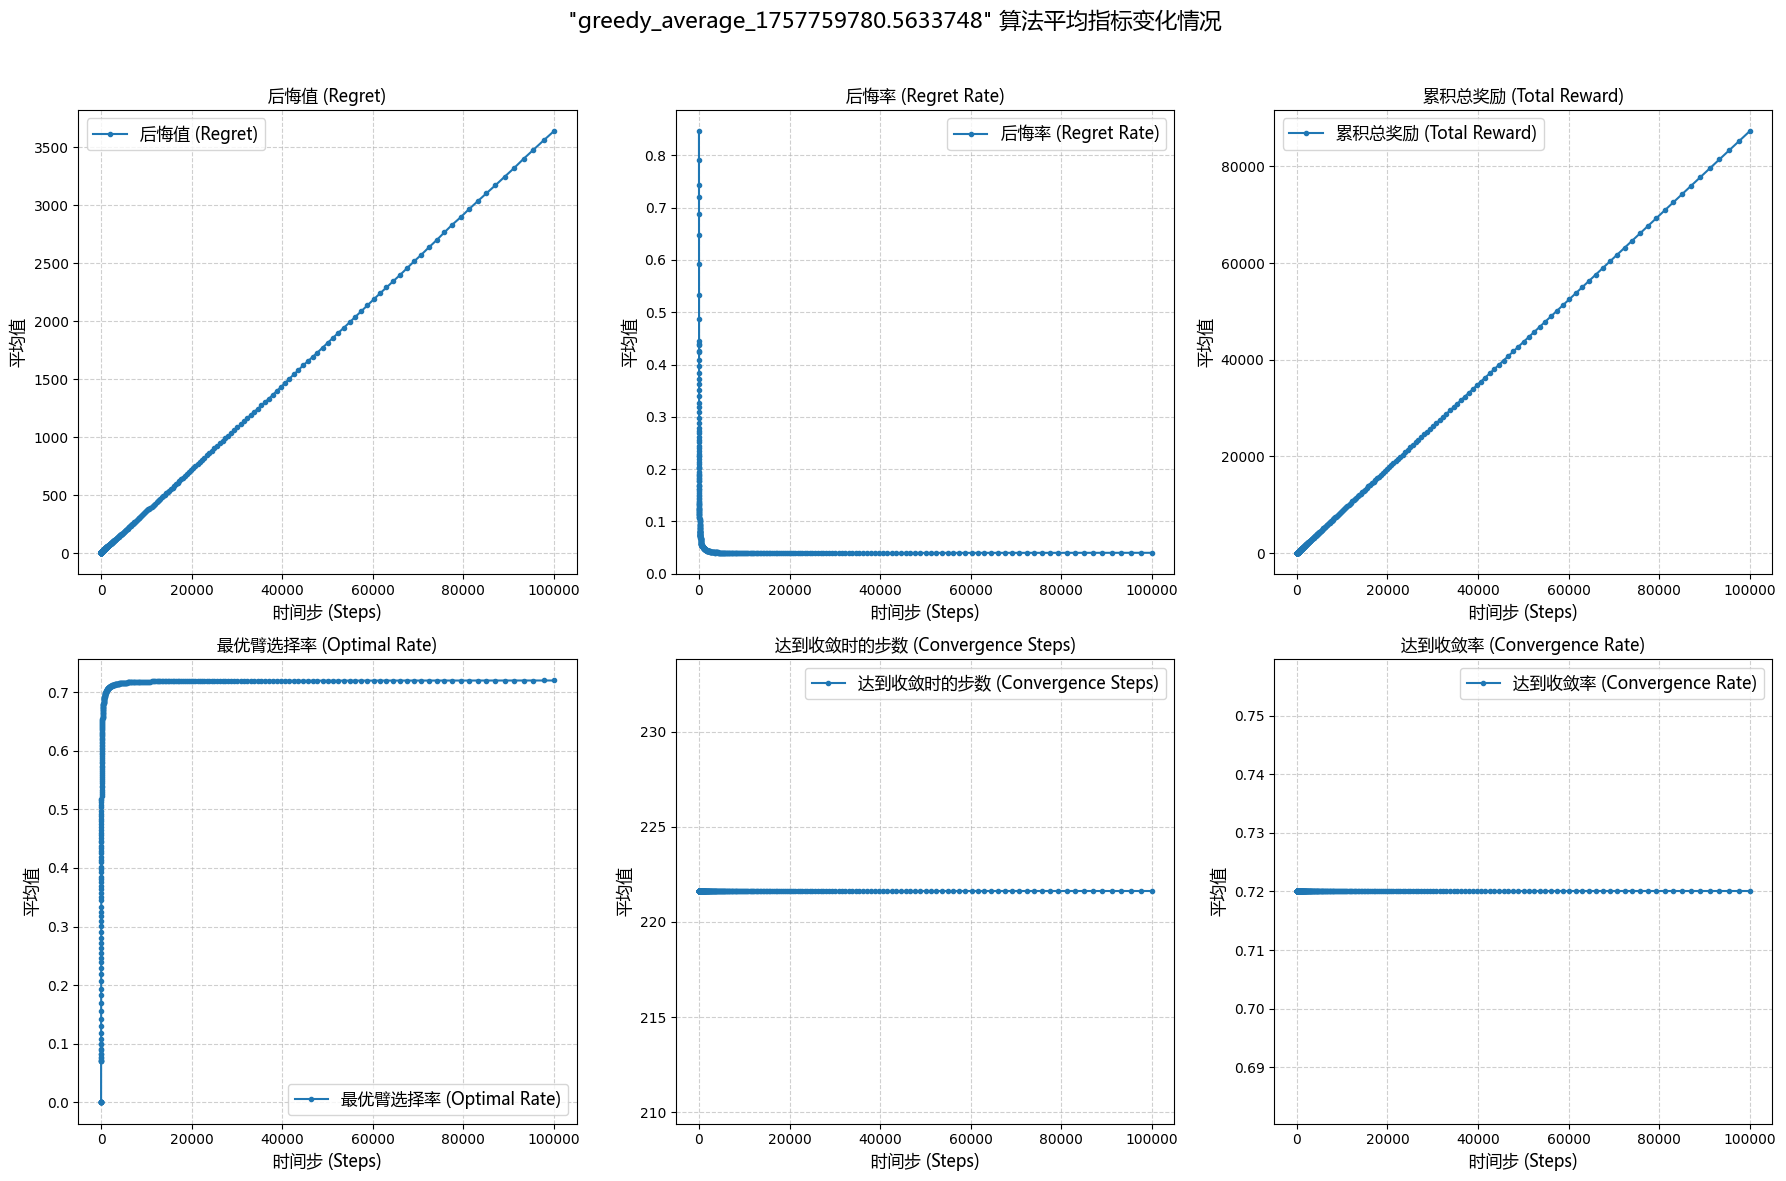

✅ 图表已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/greedy_average_1757759780.5633748_T=100000_K=10_Q_0=1.png
✅ 实验结果数据已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/greedy_average_1757759780.5633748_T=100000_K=10_Q_0=1.json
✅ 过程数据已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/greedy_average_1757759780.5633748_T=100000_K=10_Q_0=1process.json


22478

In [7]:
run_id = get_run_id(greedy_average.__name__)
file_name: Path = (
    EXPERIMENT_DATA_DIR
    / f"{run_id}_T={STEPS}_K={MACHINE_COUNT}_Q_0={OPTIMISTIC_TIMES}.png"
)
process_logger = ProcessDataLogger(
    run_id=run_id,
    total_steps=STEPS,
    grid_size=GRID_SIZE,
)

agents, reward, metrics = batch_train(
    count=RUN_COUNT,
    agent_factory=create_greedy_agent,
    env=ENV,
    epsilon_config=EPSILON_CONFIG,
    steps=STEPS,
    seed=SEED,
    optimistic_init=ENABLE_OPTIMISTIC,
    optimistic_times=OPTIMISTIC_TIMES,
    convergence_threshold=CONVERGENCE_THRESHOLD,
    convergence_min_steps=CONVERGENCE_MIN_STEPS,
    process_logger=process_logger,
)
print(metrics)
print(reward)

plot_metrics_history(agents, run_id, file_name)
save_experiment_data(reward, metrics, file_name)
process_logger.save(file_name.with_stem(file_name.stem + "process"), total_steps=STEPS)
dump = process_logger.export(total_steps=STEPS)
keys = list(dump.points[0].data.keys())

del agents, reward, metrics, process_logger, dump
gc.collect()

## UCB1算法

达到收敛时的步数: 27370
达到收敛时的步数: 22770
达到收敛时的步数: 23020
达到收敛时的步数: 21450
达到收敛时的步数: 22200
达到收敛时的步数: 26610
达到收敛时的步数: 33250
达到收敛时的步数: 26910
达到收敛时的步数: 24690
达到收敛时的步数: 24780
达到收敛时的步数: 25700
达到收敛时的步数: 18460
达到收敛时的步数: 23190
达到收敛时的步数: 20900
达到收敛时的步数: 19750
达到收敛时的步数: 23520
达到收敛时的步数: 21410
达到收敛时的步数: 22240
达到收敛时的步数: 21660
达到收敛时的步数: 33440
达到收敛时的步数: 25870
达到收敛时的步数: 29490
达到收敛时的步数: 29340
达到收敛时的步数: 27550
达到收敛时的步数: 29970
达到收敛时的步数: 27540
达到收敛时的步数: 26810
达到收敛时的步数: 23640
达到收敛时的步数: 27110
达到收敛时的步数: 26530
达到收敛时的步数: 22260
达到收敛时的步数: 21750
达到收敛时的步数: 21820
达到收敛时的步数: 24530
达到收敛时的步数: 24690
达到收敛时的步数: 17980
达到收敛时的步数: 23050
达到收敛时的步数: 22190
达到收敛时的步数: 19060
达到收敛时的步数: 27850
达到收敛时的步数: 22380
达到收敛时的步数: 30000
达到收敛时的步数: 21180
达到收敛时的步数: 27130
达到收敛时的步数: 27530
达到收敛时的步数: 22220
达到收敛时的步数: 26750
达到收敛时的步数: 25470
达到收敛时的步数: 25470
达到收敛时的步数: 24730
avg_regret=614.9509090909118 avg_regret_rate=0.006764460000000031 avg_total_reward=90294.14 avg_optimal_rate=0.9657229999999997 avg_convergence_steps=24704.2 avg_convergence_rate=1.0
values=[2.74, 6.9

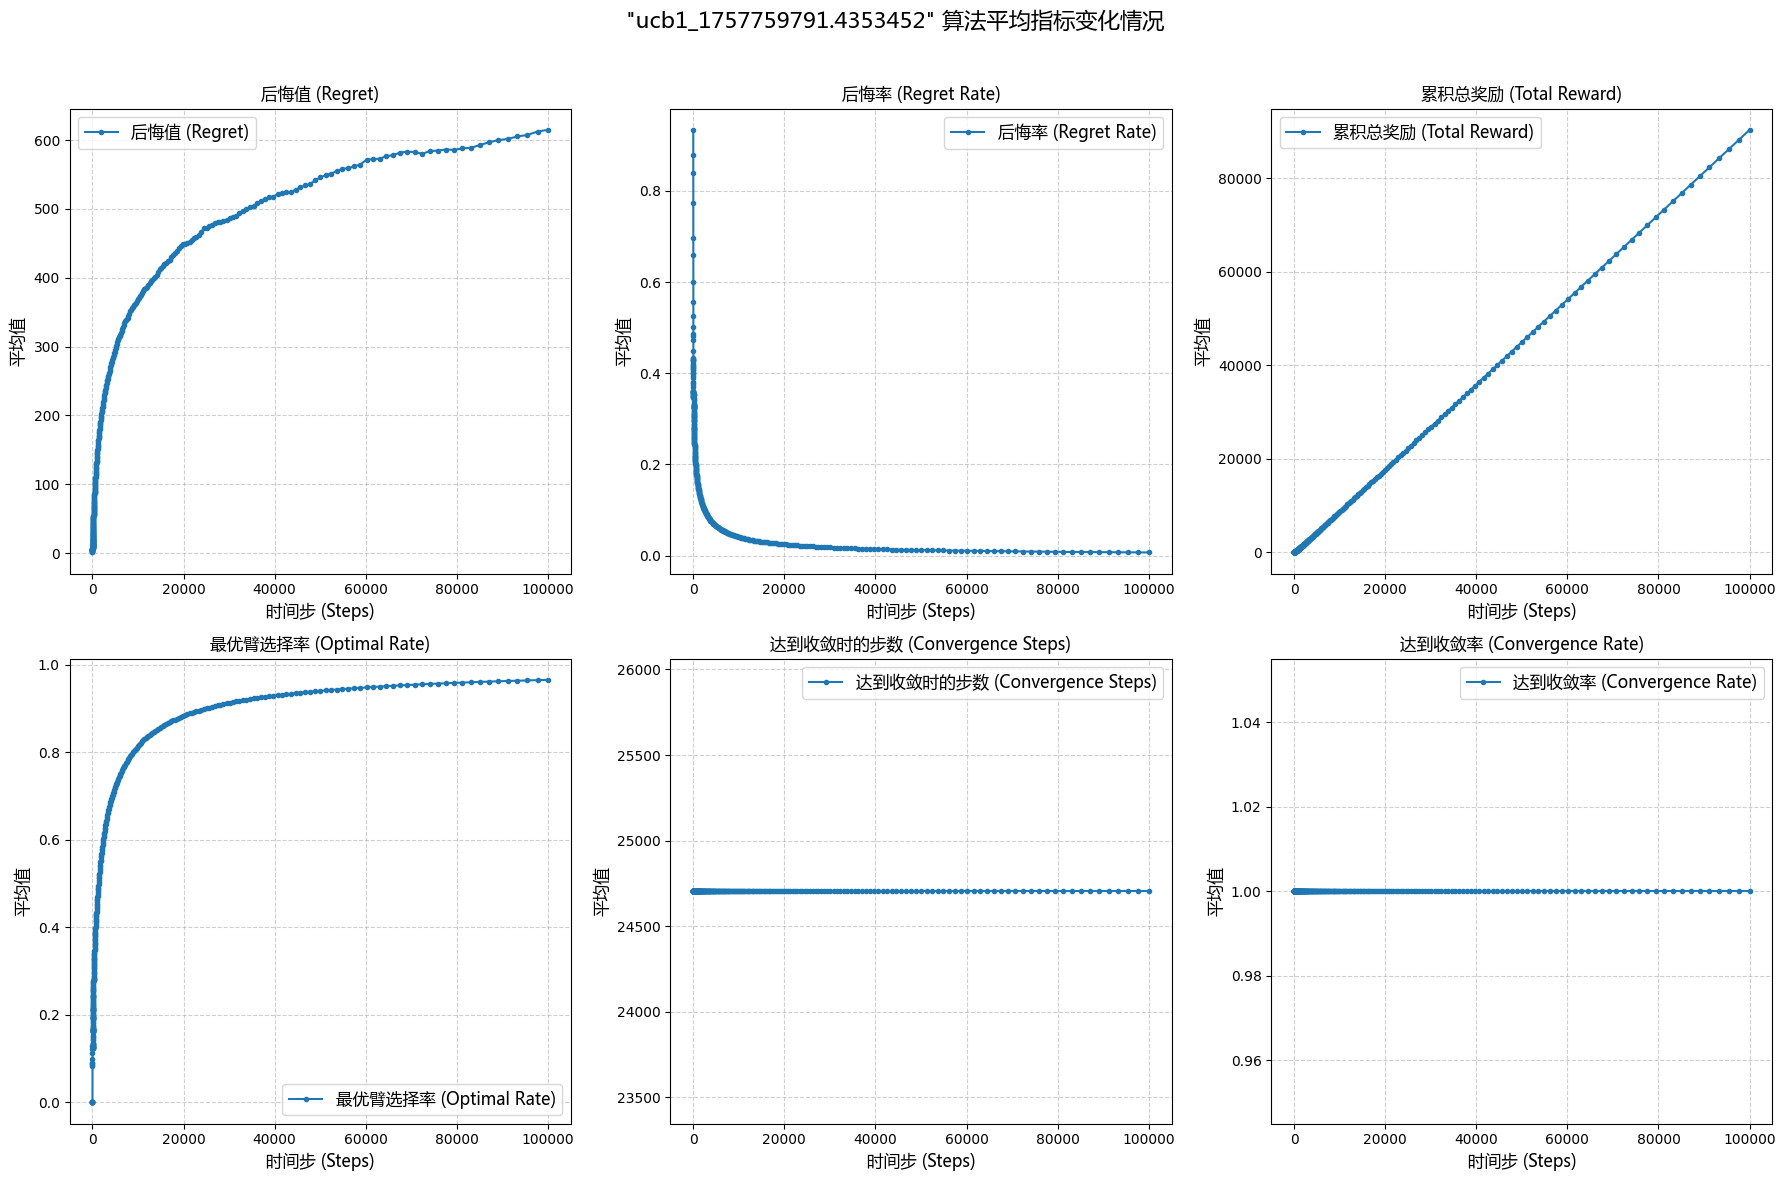

✅ 图表已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/ucb1_1757759791.4353452_T=100000_K=10_Q_0=1.png
✅ 实验结果数据已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/ucb1_1757759791.4353452_T=100000_K=10_Q_0=1.json
✅ 过程数据已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/ucb1_1757759791.4353452_T=100000_K=10_Q_0=1process.json


21487

In [8]:
run_id = get_run_id(ucb1.__name__)
file_name: Path = (
    EXPERIMENT_DATA_DIR
    / f"{run_id}_T={STEPS}_K={MACHINE_COUNT}_Q_0={OPTIMISTIC_TIMES}.png"
)
process_logger = ProcessDataLogger(
    run_id=run_id,
    total_steps=STEPS,
    grid_size=GRID_SIZE,
)

agents, reward, metrics = batch_train(
    count=RUN_COUNT,
    agent_factory=create_ucb1_agent,
    env=ENV,
    steps=STEPS,
    seed=SEED,
    convergence_threshold=CONVERGENCE_THRESHOLD,
    convergence_min_steps=CONVERGENCE_MIN_STEPS,
    process_logger=process_logger,
)
print(metrics)
print(reward)

plot_metrics_history(agents, run_id, file_name)
save_experiment_data(reward, metrics, file_name)
process_logger.save(file_name.with_stem(file_name.stem + "process"), total_steps=STEPS)
dump = process_logger.export(total_steps=STEPS)
keys = list(dump.points[0].data.keys())

del agents, reward, metrics, process_logger, dump
gc.collect()

# Thompson Sampling 算法

达到收敛时的步数: 1050
达到收敛时的步数: 610
达到收敛时的步数: 990
达到收敛时的步数: 330
达到收敛时的步数: 1260
达到收敛时的步数: 620
达到收敛时的步数: 4460
达到收敛时的步数: 950
达到收敛时的步数: 4050
达到收敛时的步数: 870
达到收敛时的步数: 1410
达到收敛时的步数: 1200
达到收敛时的步数: 1390
达到收敛时的步数: 980
达到收敛时的步数: 580
达到收敛时的步数: 1020
达到收敛时的步数: 460
达到收敛时的步数: 1120
达到收敛时的步数: 440
达到收敛时的步数: 1440
达到收敛时的步数: 770
达到收敛时的步数: 800
达到收敛时的步数: 1510
达到收敛时的步数: 2290
达到收敛时的步数: 2000
达到收敛时的步数: 630
达到收敛时的步数: 1270
达到收敛时的步数: 6610
达到收敛时的步数: 1140
达到收敛时的步数: 4070
达到收敛时的步数: 1010
达到收敛时的步数: 1450
达到收敛时的步数: 320
达到收敛时的步数: 2030
达到收敛时的步数: 1240
达到收敛时的步数: 3430
达到收敛时的步数: 1110
达到收敛时的步数: 1370
达到收敛时的步数: 930
达到收敛时的步数: 2180
达到收敛时的步数: 1100
达到收敛时的步数: 2190
达到收敛时的步数: 760
达到收敛时的步数: 540
达到收敛时的步数: 1170
达到收敛时的步数: 2280
达到收敛时的步数: 480
达到收敛时的步数: 550
达到收敛时的步数: 2590
达到收敛时的步数: 350
avg_regret=49.170909090911735 avg_regret_rate=0.0005408800000000293 avg_total_reward=90859.92 avg_optimal_rate=0.9970712 avg_convergence_steps=1468.0 avg_convergence_rate=1.0
values=[0.42, 1.16, 2.58, 3.14, 4.7, 8.66, 17.64, 32.24, 135.2, 90654.18] counts=[5.06, 6.3, 8.

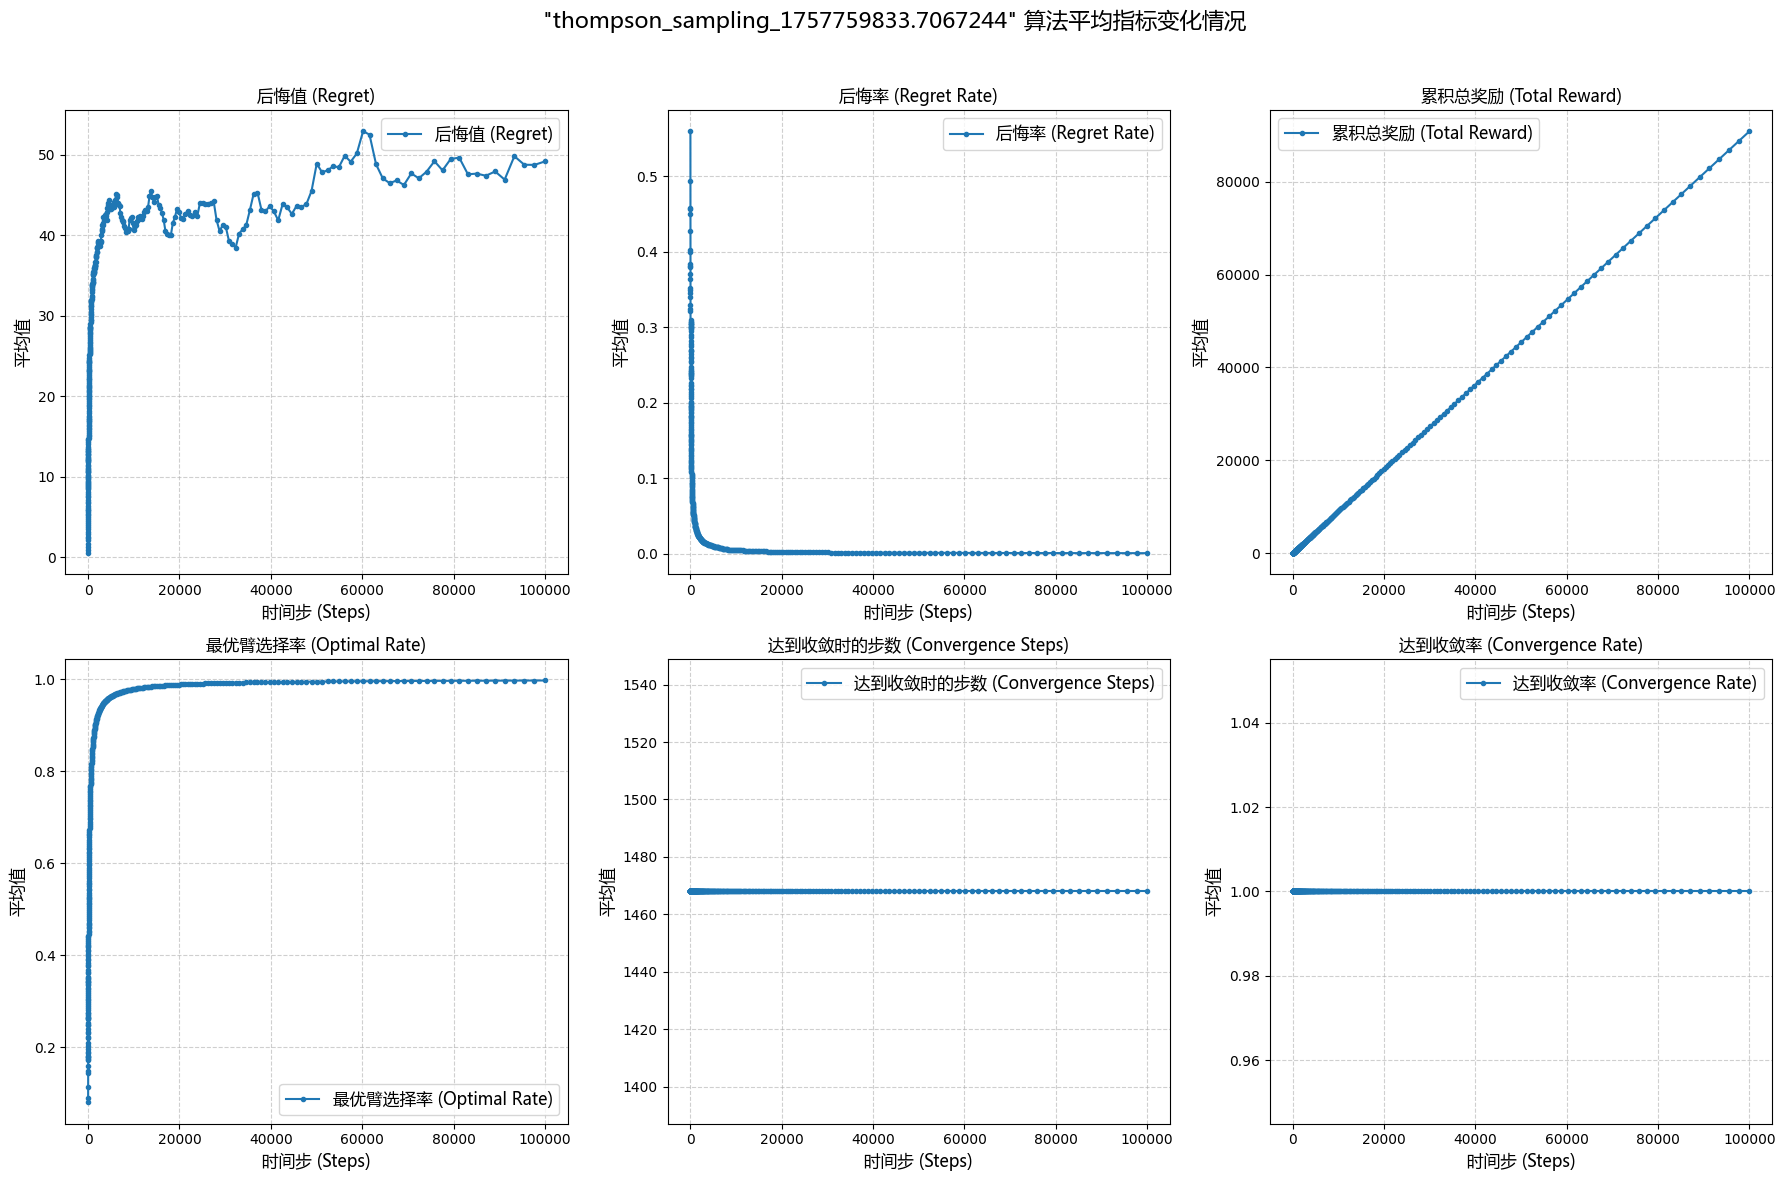

✅ 图表已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/thompson_sampling_1757759833.7067244_T=100000_K=10_Q_0=1.png
✅ 实验结果数据已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/thompson_sampling_1757759833.7067244_T=100000_K=10_Q_0=1.json
✅ 过程数据已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/thompson_sampling_1757759833.7067244_T=100000_K=10_Q_0=1process.json


21593

In [9]:
run_id = get_run_id("thompson_sampling")
file_name: Path = (
    EXPERIMENT_DATA_DIR
    / f"{run_id}_T={STEPS}_K={MACHINE_COUNT}_Q_0={OPTIMISTIC_TIMES}.png"
)
process_logger = ProcessDataLogger(
    run_id=run_id,
    total_steps=STEPS,
    grid_size=GRID_SIZE,
)

agents, reward, metrics = batch_train(
    count=RUN_COUNT,
    agent_factory=create_ts_agent,
    env=ENV,
    steps=STEPS,
    seed=SEED,
    convergence_threshold=CONVERGENCE_THRESHOLD,
    convergence_min_steps=CONVERGENCE_MIN_STEPS,
    process_logger=process_logger,
)
print(metrics)
print(reward)

plot_metrics_history(agents, run_id, file_name)
save_experiment_data(reward, metrics, file_name)
process_logger.save(file_name.with_stem(file_name.stem + "process"), total_steps=STEPS)
dump = process_logger.export(total_steps=STEPS)
keys = list(dump.points[0].data.keys())

del agents, reward, metrics, process_logger, dump
gc.collect()